In [151]:
import os
import openai
import math, random
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from dataclasses import dataclass

load_dotenv()

True

In [152]:
# let's create some classes that make managing prompts easier
@dataclass
class Solution:
    solution_name: str  # the name of the solution, e.g. "trace"
    solution_text: str  # the text solution to a problem
    value_name: str  # the name of the value used to measure the solution, e.g. "length" or "score"
    value: int  # the value of the solution, e.g. 5 or 10


class MathPrompt:
    def __init__(
        self,
        problem: str,  # text description of the problem to be solved
        instruction: str,  # instructions on what type of solution to provide and in what format
        solution_description: str,  # a description of the solutions and how they are ordered (e.g., "arranged in descending order based on their lengths, where lower values are better")
        solution_count: int = 5,  # the maximum number of solutions to include in the prompt string
        sort_ascending: bool = True,  # whether the solutions are sorted in ascending or descending order
    ):
        self.problem = problem
        self.solution_description = solution_description
        self.solutions = []
        self.instruction = instruction
        self.prompt_string = ""
        self.solution_count = solution_count
        self.sort_ascending = sort_ascending
        self.ordered_values = [] # the values of the solutions in the order they are determined by the model

    def update_prompt_string(self):
        """
        Creates a string representation of the prompt that can be used to display the prompt to the user or provide it to a language model.
        """
        solutions_string = "\n\n".join(
            f"{solution.solution_name}: {solution.solution_text}\n{solution.value_name}: {solution.value}"
            for solution in self.solutions
        )

        # only include the last solution_count solutions
        solutions_string = "\n\n".join(
            solutions_string.split("\n\n")[-self.solution_count:]
        )

        self.prompt_string = f"{self.problem}\n\n{self.solution_description}\n\n{solutions_string}\n\n{self.instruction}"

    def add_solution(self, solution: Solution):
        """
        Adds a solution to the list of solutions, sorts the list by value in ascending order, and updates the prompt string.
        """
        self.solutions.append(solution)

        self.ordered_values.append(solution.value)

        # sort the solutions by value in ascending order
        self.solutions.sort(key=lambda solution: solution.value, reverse=not self.sort_ascending)

        self.update_prompt_string()

    def __repr__(self):
        return self.prompt_string


In [153]:
# ok, let's test out the class with an example from Figure 18 the paper
problem_statement = "You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58)."
solution_description = "Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better."
instruction = "Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should traverse all points exactly once. The trace should start with <trace> and end with </trace>."

solutions = []
solutions.append(Solution(
    "trace",
    "<trace> 0,13,3,16,19,2,17,5,4,7,18,8,1,9,6,14,11,15,10,12 </trace>",
    "length",
    2254,
))
solutions.append(Solution(
    "trace",
    "<trace> 0,4,18,11,9,7,14,17,12,5,10,15,19,3,13,16,1,6,8,2 </trace>",
    "length",
    2017,
))
solutions.append(Solution(
    "trace",
    "<trace> 9,11,4,13,6,10,8,17,12,15,3,5,19,2,1,18,14,7,16,0 </trace>",
    "length",
    1953,
))
solutions.append(Solution(
    "trace",
    "<trace> 2,18,11,4,9,7,14,12,17,15,5,10,19,3,13,16,1,6,8,0 </trace>",
    "length",
    2017,
))
solutions.append(Solution(
    "trace",
    "<trace> 11,0,4,13,6,10,8,17,12,3,15,5,19,2,1,18,14,7,16,9 </trace>",
    "length",
    1953,
))

test_problem = MathPrompt(problem_statement, instruction, solution_description, solution_count=4, sort_ascending=False)

for solution in solutions:
    test_problem.add_solution(solution)

print(test_problem) # should only show two solutions in the prompt

print(f"\n\nThere are actually {len(test_problem.solutions)} solutions in the problem's structure.")

You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 0,4,18,11,9,7,14,17,12,5,10,15,19,3,13,16,1,6,8,2 </trace>
length: 2017

trace: <trace> 2,18,11,4,9,7,14,12,17,15,5,10,19,3,13,16,1,6,8,0 </trace>
length: 2017

trace: <trace> 9,11,4,13,6,10,8,17,12,15,3,5,19,2,1,18,14,7,16,0 </trace>
length: 1953

trace: <trace> 11,0,4,13,6,10,8,17,12,3,15,5,19,2,1,18,14,7,16,9 </trace>
length: 1953

Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should

In [154]:
# ok, that matches the example from the paper pretty well. now we need a quick utility function to calculate the total distance covered in a trace
points = [
        (-4, 5),
        (17, 76),
        (-9, 0),
        (-31, -86),
        (53, -35),
        (26, 91),
        (65, -33),
        (26, 86),
        (-13, -70),
        (13, 79),
        (-73, -86),
        (-45, 93),
        (74, 24),
        (67, -42),
        (87, 51),
        (83, 94),
        (-7, 52),
        (-89, 47),
        (0, -38),
        (61, 58),
    ]

def calculate_trace_length(points: list, trace: str):
    """
    Calculates the total distance covered in a trace. Assumes that the trace is a string of comma-separated integers, where each integer represents a point.
    """
    # remove <trace> and </trace> tags in case they were provided, and remove any leading / trailing whitespace
    trace = trace.replace("<trace>", "").replace("</trace>", "").strip()

    # if the trace consists of anything other than comma-separated integers, return inf and let the user know that the trace is invalid
    if not all(char.isdigit() or char == "," for char in trace):
        print("The trace should consist of comma-separated integers.")
        return math.inf

    # if the wrong number of points were chosen, return inf and let the user know that the trace is invalid
    if len(trace.split(",")) != len(points):
        print(f"Expected {len(points)} points in the trace, but {len(trace.split(','))} were found.")
        return math.inf
    
    # if any points were missed, return inf and let the user know that the trace is invalid
    for i in range(len(points)):
        if str(i) not in trace:
            print(f"Point {i} was not visited in the trace.")
            return math.inf

    chosen_points = [points[int(point)] for point in trace.split(",")]
    
    total_distance = 0

    for i in range(len(chosen_points) - 1):
        total_distance += math.dist(chosen_points[i], chosen_points[i + 1])

    # round to the nearest integer
    return round(total_distance)

# let's make another utility function that generates some random solutions
def generate_random_solutions(points: list, num_solutions: int = 5):
    solutions = []

    for i in range(num_solutions): 
        random_ordering = list(range(len(points)))  # convert range to list
        random.shuffle(random_ordering)  # shuffle the list in-place
        trace = f"<trace> {','.join(map(str, random_ordering))} </trace>"  # convert integers to strings before joining
        solutions.append(Solution("trace", trace, "length", calculate_trace_length(points, trace)))

    return solutions

In [155]:
# let's make sure this works
print(calculate_trace_length(points, "<trace> 0,13,3,16,19,2,17,5,4,7,18,8,1,9,6,14,11,15,10,12 </trace>")) # should be 2254
print(calculate_trace_length(points, "<trace> 0,18,4,11,9,7,14,17,12,15,10,5,19,3,13,16,1,6,8,2 </trace>")) # should be 2017

# and let's print some random solutions
print(f"\nRandom solutions:")
for solution in generate_random_solutions(points):
    print(solution)

2174
2010

Random solutions:
Solution(solution_name='trace', solution_text='<trace> 19,11,14,17,15,16,3,4,5,12,0,6,1,18,10,13,9,7,8,2 </trace>', value_name='length', value=2159)
Solution(solution_name='trace', solution_text='<trace> 0,16,2,3,6,10,7,1,14,13,18,15,4,5,17,11,8,12,9,19 </trace>', value_name='length', value=1927)
Solution(solution_name='trace', solution_text='<trace> 0,19,13,12,2,15,1,8,16,4,5,10,18,17,9,14,11,7,6,3 </trace>', value_name='length', value=2087)
Solution(solution_name='trace', solution_text='<trace> 0,10,2,9,18,15,8,4,1,11,5,3,14,7,12,13,17,16,19,6 </trace>', value_name='length', value=2097)
Solution(solution_name='trace', solution_text='<trace> 5,13,12,2,15,0,7,17,1,19,6,14,8,3,11,18,16,9,4,10 </trace>', value_name='length', value=1971)


In [156]:
# ok, those were close enough; now let's start working on feeding the problems to a model
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_new_trace(prompt: str, model: str = "gpt-3.5-turbo"):
  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": "You are a helpful assistant who helps users solve math problems You respond ONLY with the answer in the format the user directs."},
      {"role": "user", "content": prompt},
    ]
  )

  return completion.choices[0].message.content



In [157]:
# let's test it out!
get_new_trace(test_problem.prompt_string)

'<trace> 15,3,19,5,10,7,16,11,0,4,13,6,8,17,12,2,18,14,1,9 </trace>'

In [158]:
# now let's put it all together and try to get 3.5-turbo to solve the problem!
starting_solutions = generate_random_solutions(points, num_solutions=3)
gpt_35_turbo_problem = MathPrompt(problem_statement, instruction, solution_description, solution_count=10, sort_ascending=False)

for solution in starting_solutions:
    gpt_35_turbo_problem.add_solution(solution)

print(gpt_35_turbo_problem)



You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 15,11,3,4,9,0,18,19,6,5,13,16,2,8,7,10,14,17,12,1 </trace>
length: 2349

trace: <trace> 14,13,1,6,0,5,18,12,16,2,15,9,3,8,7,4,17,19,10,11 </trace>
length: 2253

trace: <trace> 5,3,15,8,2,1,19,9,10,0,17,7,13,18,11,4,14,6,16,12 </trace>
length: 2234

Give me a new trace that is different from all traces above, and has a length lower than any of the above. The trace should traverse all points exactly once. The trace should start with <trace> and end with </tr

In [159]:
def solve_traveling_salesman(problem: MathPrompt, max_iters: int = 20, batch_size: int = 4, model = "gpt-3.5-turbo"):
    """
    Solves a traveling salesman problem using GPT-3.5-turbo.

    Args:
    - problem: a MathPrompt object
    - max_iters: the maximum number of iterations to run
    - batch_size: the number of solutions to generate per iteration
    """
    no_improvement_counter = 0
    failure_counter = 0
    api_count = 0
    for i in range(max_iters):
        solutions = []
        for j in range(batch_size):
            new_trace = get_new_trace(problem.prompt_string)
            new_length = calculate_trace_length(points, new_trace)

            if problem.sort_ascending:
                if new_length < problem.solutions[0].value:
                    no_improvement_counter += 1
            else:
                if new_length > problem.solutions[0].value:
                    no_improvement_counter += 1
            api_count += 1

            # if inf or -inf, then count a failure
            if new_length == math.inf or new_length == -math.inf:
                failure_counter += 1
            else:
                solutions.append(Solution("trace", new_trace, "length", new_length))

        for solution in solutions: # add all solutions from a batch at once
            problem.add_solution(solution)

        if no_improvement_counter > max_iters * batch_size / 3:
            print(f"Stopping early after {i} iterations without improvement.")
            print(f"There were {failure_counter} failures out of {api_count} API calls.")
            break

    print(f"There were {failure_counter} failures out of {api_count} API calls.")
    return problem


In [160]:
solve_traveling_salesman(gpt_35_turbo_problem, max_iters=12)


There were 0 failures out of 4 API calls.


You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 5,3,15,8,2,1,19,9,18,7,13,17,4,11,6,12,14,10,16,0 </trace>
length: 2389

trace: <trace> 15,11,3,4,9,0,18,19,6,5,13,16,2,8,7,10,14,17,12,1 </trace>
length: 2349

trace: <trace> 12,16,2,15,9,3,8,7,4,17,19,10,11,14,13,1,6,0,5,18 </trace>
length: 2295

trace: <trace> 14,13,1,6,0,5,18,12,16,2,15,9,3,8,7,4,17,19,10,11 </trace>
length: 2253

trace: <trace> 5,3,15,8,2,1,19,9,10,0,17,7,13,18,11,4,14,6,16,12 </trace>
length: 2234

trace: <trace> 15,11,3,4,9,0,18,19,

In [163]:
# let's do gpt-4 and compare (using the same starting solutions)
gpt4_problem = MathPrompt(problem_statement, instruction, solution_description, solution_count=10, sort_ascending=False)

for solution in starting_solutions:
    gpt4_problem.add_solution(solution)

solve_traveling_salesman(gpt4_problem, max_iters=12, model="gpt-4")

There were 0 failures out of 4 API calls.


You are given a list of points with coordinates below: (0): (-4, 5), (1): (17, 76), (2): (-9, 0), (3): (-31, -86), (4): (53, -35), (5): (26, 91), (6): (65, -33), (7): (26, 86), (8): (-13, -70), (9): (13, 79), (10): (-73, -86), (11): (-45, 93), (12): (74, 24), (13): (67, -42), (14): (87, 51), (15): (83, 94), (16): (-7, 52), (17): (-89, 47), (18): (0, -38), (19): (61, 58).

Below are some previous traces and their lengths. The traces are arranged in descending order based on their lengths, where lower values are better.

trace: <trace> 15,11,3,4,9,0,18,19,6,5,13,16,2,8,7,10,14,17,12,1 </trace>
length: 2349

trace: <trace> 14,17,4,12,16,6,19,18,0,8,2,15,9,3,5,13,7,10,11,1 </trace>
length: 2271

trace: <trace> 14,13,1,6,0,5,18,12,16,2,15,9,3,8,7,4,17,19,10,11 </trace>
length: 2253

trace: <trace> 5,3,15,8,2,1,19,9,10,0,17,7,13,18,11,4,14,6,16,12 </trace>
length: 2234

trace: <trace> 5,3,15,8,2,1,19,9,10,0,17,7,13,18,11,4,14,6,16,12 </trace>
length: 2234

trace: <trace> 5,14,10,2,8,1,6,17,1

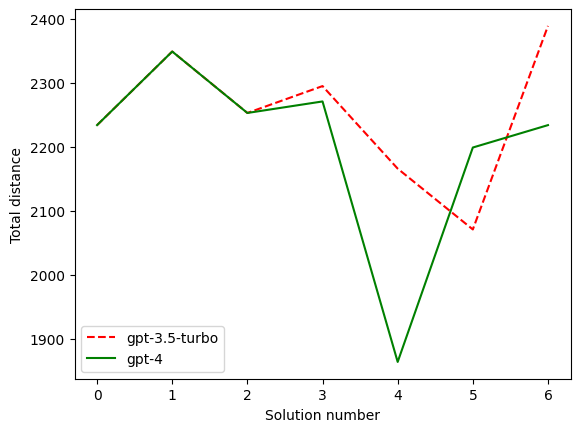

In [164]:
# add the gpt-4 results to the plot, compare to gpt_35_turbo
plt.plot(gpt_35_turbo_problem.ordered_values, linestyle="--", color="red")
plt.plot(gpt4_problem.ordered_values, color="green")
plt.legend(["gpt-3.5-turbo", "gpt-4"])
plt.ylabel('Total distance')
plt.xlabel('Solution number')
plt.show()